In [79]:
import sys
print sys.path

import psycopg2 as ppg

con = ppg.connect("dbname=tweets user=patrick")
print con

['', '/home/patrick/anaconda/lib/python27.zip', '/home/patrick/anaconda/lib/python2.7', '/home/patrick/anaconda/lib/python2.7/plat-linux2', '/home/patrick/anaconda/lib/python2.7/lib-tk', '/home/patrick/anaconda/lib/python2.7/lib-old', '/home/patrick/anaconda/lib/python2.7/lib-dynload', '/home/patrick/anaconda/lib/python2.7/site-packages/cryptography-0.8-py2.7-linux-x86_64.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/setuptools-17.0-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages', '/home/patrick/anaconda/lib/python2.7/site-packages/Sphinx-1.2.3-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/IPython/extensions']
<connection object at 0x7f90f999a5c8; dsn: 'dbname=tweets user=patrick', closed: 0>


In [3]:
#cur = con.cursor()
#cur.execute("SELECT tweet_id FROM tweets;")
#tweet_id = set(zip(*cur.fetchall())[0])
#cur.close()

Populating the interactive namespace from numpy and matplotlib
freq    253179
dtype: int64


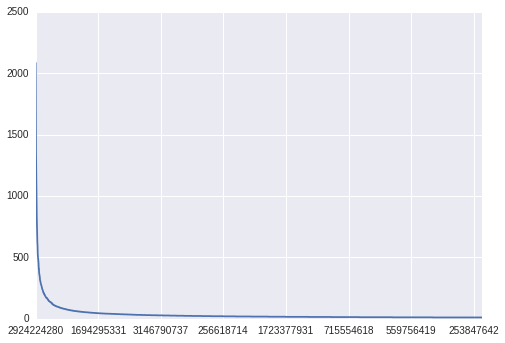

In [3]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

with con.cursor() as cur:
    cur.execute("SELECT user_id FROM tweets;")
    users = zip(*cur.fetchall())[0]

user_counts = pd.DataFrame({ 'freq': pd.Series(users).value_counts() })
user_counts[user_counts.freq>10].freq.plot()
print user_counts[user_counts.freq>10].sum()

In [5]:
# with con.cursor() as cur:
#     cur.execute("SELECT tweet_id, user_id, in_reply_to_tweet_id FROM tweets")
#     tweets_list = cur.fetchall()
# tweets = pd.DataFrame(tweets_list, columns=['tweet_id','user_id','reply_id']).set_index('tweet_id')
# %timeit replied_to = tweets[tweets.reply_id != 'None'].reply_id.values
# tweet_ids = set(tweets.index)
# %timeit questions = tweets[[twid in replied_to for twid in tweet_ids]]
# print questions

In [6]:
# replies = tweets[tweets.reply_id != 'None']
# hanging_questions= pd.Series([rid for rid in replies.reply_id if rid not in questions.tweet_id.values])
# print hanging_questions

Base rate of @-mentions
Base rate of in-reply-to's
Find variation across users in in-reply-to's/total num. tweets
Ratio by user of outgoing @mention rate to in-reply-to (to all that user's tweets)

In [64]:
# # annotate tweets with initial @mention rate
# at_ment_re = re.compile(r"^\s+\.?@")
# tweets['at_mention'] = tweets.text.apply(lambda x:
#      at_ment_re.search(x) is not None)
                                         

# users_grps = tweets.groupby('user_id')
# users_df = users_grps.apply(lambda x: pd.DataFrame({'num_at_out': x.at_mention.sum(),
#                                                     'num_at_in': 
#reload(seaborn)
con.rollback()

In [80]:
# Explore geotags
usa = (-125.6791025,25.4180700649,-66.885417,
                           49.3284551525)    
with con.cursor() as cur:
    cur.execute("SELECT tw.tweet_id, tw.user_id, tw.lat, tw.long, user_locs.place, plcs.place_lat, "
                "plcs.place_long "
                "FROM tweets as tw, (SELECT user_id, place FROM users) as user_locs, "
                "(SELECT place, coded_lat as place_lat, coded_long as place_long FROM "
                "places) as plcs "
                "WHERE tw.user_id = user_locs.user_id and user_locs.place != 'None' "
                "and plcs.place = user_locs.place AND plcs.place_lat != -500 AND "
                "plcs.place_long != 500 AND (user_locs.place ~* '[A-Z\s]+,\s*[A-Z]+' OR "
                "user_locs.place ~* '(New York City|NYC|LA|Los Angeles|Chicago|DC|SF|San Francisco|"
                "Detroit|Houston|Dallas|Atlanta|Philly|Philadelphia|Phoenix|San Antonio| "
                "San Jose|Austin|Jacksonville|Indianapolis|Denver)');")
    geotags = pd.DataFrame(cur.fetchall(), 
                       columns=["tweet_id","user_id","tweet_lat","tweet_long","user_location",
                               "user_lat", "user_long"])
    in_us = pd.Series((geotags['tweet_long'] > usa[0]) & (geotags['tweet_long'] < usa[2]) &
                        (geotags['tweet_lat'] > usa[1]) & (geotags['tweet_lat'] < usa[3]))
    print in_us
    geotags['in_us'] = in_us
    # look at distance between user location and tweet location
 
    geotags['tweet_distance'] = np.sqrt((geotags.user_lat - geotags.tweet_lat) ** 2 + 
                                        (geotags.user_long - geotags.tweet_long) ** 2)
    geotags['on_road'] = geotags['tweet_distance'] > 0.5
    
    # get number of users w/ any on-road tweets, other per-user stats
    users_on_road=geotags.groupby('user_id').apply(lambda x: pd.Series([x.on_road.any(), x.on_road.sum(), x.shape[0]],
             index=['any_on_road','num_on_road','num_tweets_user'])).reset_index()
    geotags = geotags.merge(users_on_road, on='user_id')
    


0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
...
130248    True
130249    True
130250    True
130251    True
130252    True
130253    True
130254    True
130255    True
130256    True
130257    True
130258    True
130259    True
130260    True
130261    True
130262    True
Length: 130263, dtype: bool


In [37]:
print "Number NA user lat/long: " + str(geotags[['user_id', 'user_lat']].drop_duplicates().user_lat.isnull().sum())
print geotags.shape
geotags.head(10)

Number NA user lat/long: 0
(120859, 13)


,tweet_id,user_id,tweet_lat,tweet_long,user_location,user_lat,user_long,in_us,tweet_distance,on_road,any_on_road,num_on_road,num_tweets_user
0,608746364433014784,92652781,37.768900,-122.474176,Los Angeles,34.052227,-118.243680,True,5.631230,True,True,3,4
1,606606914382884864,92652781,37.775000,-122.418000,Los Angeles,34.052227,-118.243680,True,5.593209,True,True,3,4
2,608699447028121601,92652781,37.793230,-122.414480,Los Angeles,34.052227,-118.243680,True,5.602738,True,True,3,4
3,606539785600000000,92652781,34.196338,-118.352430,Los Angeles,34.052227,-118.243680,True,0.180540,False,True,3,4
4,608746355452870656,55979584,30.013785,-95.468449,"Houston, TX",29.763276,-95.363269,True,0.271694,False,False,0,1
5,606545644589715459,198020747,33.733886,-84.349284,Atlanta,33.748999,-84.387978,True,0.041541,False,False,0,1
6,606545674658643969,1262061,43.890851,-78.938497,"Whitby, ON",43.897545,-78.942933,True,0.008030,False,False,0,30
7,608004322232823808,1262061,43.890811,-78.938396,"Whitby, ON",43.897545,-78.942933,True,0.008119,False,False,0,30
8,608330462243766272,1262061,43.890811,-78.938403,"Whitby, ON",43.897545,-78.942933,True,0.008116,False,False,0,30
9,608330644238835712,1262061,43.890852,-78.938498,"Whitby, ON",43.897545,-78.942933,True,0.008029,False,False,0,30


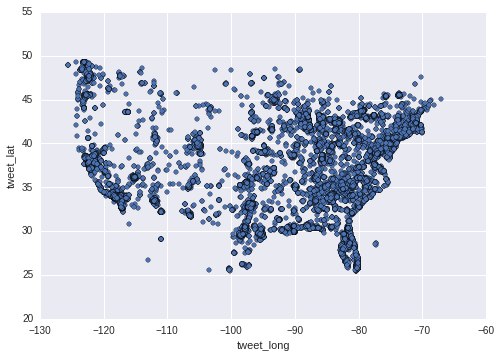

In [65]:
geotags[geotags['in_us']==True].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#LA

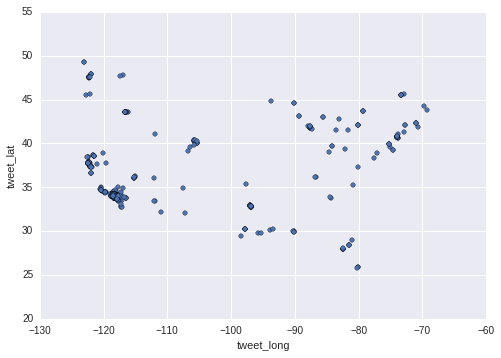

In [21]:
geotags[geotags['user_location']=="Los Angeles, CA"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#NYC

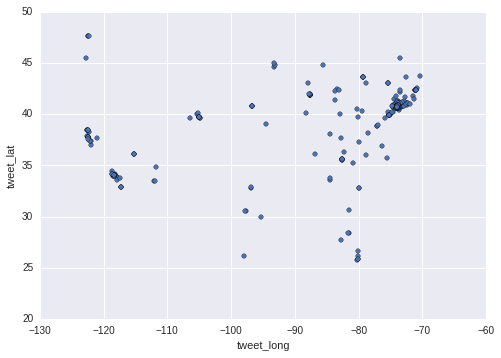

In [22]:
geotags[geotags['user_location']=="New York, NY"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

3                 Appleton, WI
4                Champaign, IL
13               New York City
14              Greenville, NC
27                    Chicago 
29                Indianapolis
30                  Albany, NY
32                 Seattle, WA
37                Arizona, USA
38    Pittsburgh, Pennsylvania
39         Boca Raton, Florida
41             California, USA
47                Columbia, MO
50                 Atlanta, GA
55                Philadelphia
...
90695                    Atlanta,GA
91078                   Boston, MA 
91911    Philadelphia, Pennsylvania
92507                Abilene, Texas
93387                San Antonio,TX
95249                Sioux City, IA
95256              Bozeman, Montana
95550            Fresno, California
96239            Hermosillo, Sonora
96247                   Compton, CA
96863                   Bozeman, MT
97353                  Buffalo, NY 
97527               Vancouver, B.C.
97905            East Nashville, TN
98452                   orl

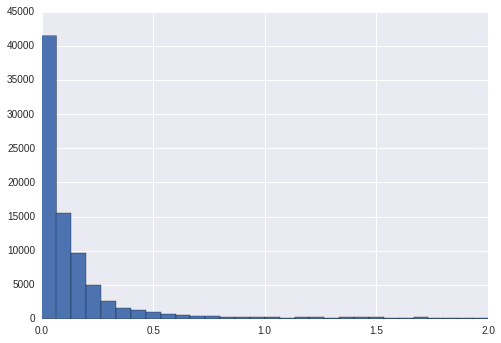

In [5]:
#print geotags.ix[np.argmax(geotags['tweet_distance'])]
#((geotags.user_lat - geotags.tweet_lat) ** 2).describe()
geotags[geotags.tweet_distance < 2].tweet_distance.hist(bins=30)
print geotags[geotags.tweet_distance > 0.5].user_location.drop_duplicates()


                 tweet_id    user_id  tweet_lat  tweet_long user_location  \
33653  608486881223819264  372874115  42.632968  -95.248412    Ames, Iowa   
33654  606594147193995264  372874115  42.631812  -95.635601    Ames, Iowa   
33655  606595148995117057  372874115  42.569793  -95.717870    Ames, Iowa   
33656  608374153457082369  372874115  42.632822  -95.248318    Ames, Iowa   
33657  608375620343611392  372874115  42.633106  -95.248587    Ames, Iowa   
33658  608381718077284352  372874115  42.632911  -95.248348    Ames, Iowa   

        user_lat  user_long in_us  tweet_distance on_road any_on_road  \
33653  42.034722     -93.62  True        1.734827    True        True   
33654  42.034722     -93.62  True        2.102181    True        True   
33655  42.034722     -93.62  True        2.165031    True        True   
33656  42.034722     -93.62  True        1.734688    True        True   
33657  42.034722     -93.62  True        1.735039    True        True   
33658  42.034722     -

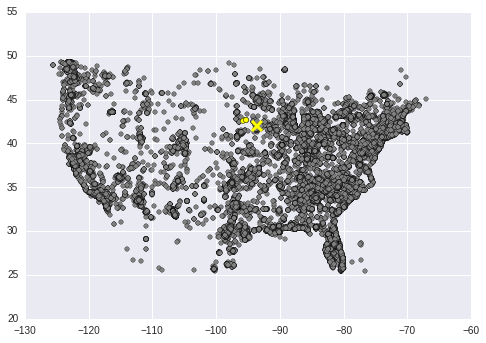

In [71]:
import random
plt.scatter(geotags[geotags['in_us']==True]['tweet_long'],geotags[geotags['in_us']==True]['tweet_lat'],
           c='gray')
# random user's home location
random_user = geotags.loc[random.sample(geotags[geotags.on_road].index, 1), 'user_id']


user_tweets = geotags[geotags['user_id']==random_user.values[0]]
print user_tweets
plt.scatter(user_tweets.tweet_long, user_tweets.tweet_lat,
            c='yellow', marker='.', s=100)
plt.scatter(user_tweets.user_long.drop_duplicates(), user_tweets.user_lat.drop_duplicates(), 
            c='yellow', marker='x', linewidth = '3', s=100)


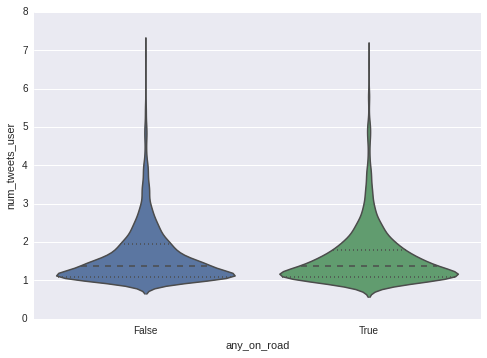

In [121]:
# compare number of tweets between on/off road
tweet_freqs = geotags[(geotags['num_tweets_user'] >= 3)][['user_id','num_tweets_user','any_on_road']]. \
    drop_duplicates()
#plt.axis([None, None, 0,5])

seaborn.violinplot(tweet_freqs.num_tweets_user.map(np.log), groupby=tweet_freqs.any_on_road)

In [81]:
# do logistic regression on topic features
with con.cursor() as cur:
    cur.execute("SELECT user_id, " +
               ', '.join(["topic_{}".format(x) for x in range(0,40)]) +
               " FROM users WHERE topic_0 is not NULL")
    topic_matrix = pd.DataFrame(cur.fetchall(), columns = ["user_id"] + 
                           ["topic_{}".format(x) for x in range(0,40)])
geotopics = topic_matrix.merge(geotags[['user_id','any_on_road']].drop_duplicates(), on='user_id', how='left') 



In [82]:
print geotopics.dropna().any_on_road.shape[0]
print geotopics.dropna().any_on_road.sum()

response = geotopics.dropna()['any_on_road']
predictors = geotopics.dropna().loc[:,'topic_0':'topic_39']

39190
10568


In [106]:
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as skpre
import sklearn.cross_validation as skcv

random.seed(888)
train, test = skcv.train_test_split(pd.concat([pd.DataFrame(response), predictors], axis = 1))
train = pd.DataFrame(train, columns = ["any_on_road"] + predictors.columns.tolist())
test = pd.DataFrame(test, columns = ["any_on_road"] + predictors.columns.tolist())

scaler = skpre.StandardScaler()
scaler.fit(train.loc[:,"topic_0":"topic_39"])
train_scaled = scaler.transform(train.loc[:,"topic_0":"topic_39"])
test_scaled = scaler.transform(test.loc[:,"topic_0":"topic_39"])
#predictors_scaled = skpre.scale(predictors)
#test

In [107]:
logmodel = LogisticRegression()
model_results = logmodel.fit(train.loc[:,"topic_0":"topic_39"],train["any_on_road"])


In [110]:
print float((test.any_on_road == False).sum())/float(test.shape[0])
print float((model_results.predict(test_scaled) == test.any_on_road).sum())/float(test.shape[0])
print (model_results.predict(test_scaled) == True).sum()

0.731067564809
0.609308022045
3809


In [ ]:
# try SVM
from sklearn import svm
svmachine = svm.SVC(class_weights='auto')
model_results = svmachine.fit(train_scaled,train.any_on_road)

In [115]:
print float((test.any_on_road == False).sum())/float(test.shape[0])
print float((model_results.predict(test_scaled) == test.any_on_road).sum())/float(test.shape[0])

0.731067564809
0.731067564809
